# Springboard - Data Science Career Track

# Capstone Project I: Kiva.org loan delays

In [1]:
# link for the data
kiva_url = "https://www.kaggle.com/lucian18/mpi-on-regions#all_kiva_loans.csv"

### Goal of the project:
    
**Understand what may cause a higher delay between:**

-  the "posted time" (the time at which the loan is posted on Kiva by the field agent)
-  the "funded time" (the time at which the loan posted to Kiva gets 100% funded by lenders)
- the "disbursed time" (the time at which the loan is disbursed by the field agent to the borrower)

#### **The journey of a Kiva loan**

- A borrower applies for a loan.
- The loan goes through the underwriting and approval process
- If it is approved, the loan disbursal period starts
    - The loan is posted to Kiva for lenders to support
    - Fundraising period
    - Fundraising complete (or not)
- Borrower repays the loan
- Lenders use repayments to fund new loans, donate or withdraw the money.

Partner loans are administered by Kiva’s Field Partners and are available to borrowers in more than 80 countries. Direct loans are made using the digital payment system and don’t involve a Field Partner.

**Note**: *Disbursal* refers to when the borrower can access the money, but the timing of it can vary:    
  - For most Field Partner loans, the money is *pre-disbursed* (when partners give the funds out before the loan is posted), so the borrower can access the funds right away. 
  - For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

**Table of contents:**

[3) Modeling](#modeling)

[4) Dimension Reduction & Feature Selection](#dim_red)

[5) Hyperparameter Tuning](#tuning)

[6) Conclusion](#conclusion)


### Libraries

In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore, normaltest, shapiro, norm, t
from collections import Counter
sns.set()
from scipy import stats
import scipy
import statsmodels.api as sm

## 1) Data inspection and Cleaning
<a id="data_cleaning"></a>

* https://github.com/MigBap/Springboard-Capstone-Project-I/blob/master/Capstone%20Project%20I%20--%201)%20Data%20inspection%20and%20Cleaning.ipynb

## 2) Exploratory Data Analysis
<a id="eda"></a>

* https://github.com/MigBap/Springboard-Capstone-Project-I/blob/master/Capstone%20Project%20I%20--%20%202)%20Exploratory%20Data%20Analysis.ipynb

In [ ]:
%%capture
%run "Capstone Project I --  2) Exploratory Data Analysis.ipynb"

## 3) Modeling
<a id="modeling"></a>

In [191]:
# final_df
final_df.head()

,real_time,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,...,partner_id_386.0,partner_id_428.0,partner_id_455.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,country_name_other,partner_id_other,currency_other
0,3,700.0,10.0,15,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,4,1000.0,12.0,15,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,4,1600.0,18.0,18,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,600.0,15.0,6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,6,450.0,9.0,10,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


## Classification | "high" vs "low" delay

We will treat the problem as a **classification problem**. The goal will be to classifiy a loan with either a **"high" loan delay**, that is, a loan that takes more than the median delay of all the loans in the data, or with a **"low" loan delay**, meaning that it will take less than the median, which in this case is equal to 26 days.

* "high" loan delay: a loan that takes more than 26 days to fund: 1
* "low" loan delay: a loan that takes less than 26 days to fund: 0

**Building a classification dataframe both for linear (scaling numeric variables) and non-linear cases:**

### *Linear Models*

In [192]:
# use
linear_df = final_df.copy()

Removing highly correlated variables.

**Repayment intervals:** I will remove all repayment intervals other than irregular ones, due to its high inverse correlation with the others, who are most similar.

In [193]:
# keep only repayment_interval_irregular (55% of the data)
linear_df = linear_df.drop(['repayment_interval_bullet', 'repayment_interval_monthly', 'repayment_interval_weekly'], axis=1)

**Currency policy:** I will keep only shared currency policies. It is either shared or not.

In [194]:
# keep only shared currency policies
linear_df = linear_df.drop('currency_policy_not shared', axis=1)

**num_lenders_total**: highly correlated with loan_amount

In [195]:
# keep loan_amount instead
linear_df = linear_df.drop('num_lenders_total', axis=1)

Linear classification dataframe

In [196]:
# linear_df_class
linear_df_class = linear_df.copy()

# build the target variable
real_time_class = []

# median time delay
real_time_median = np.median(final_df['real_time'])  
print("Median time delay: {}".format(real_time_median))

# create class column
for i in linear_df_class['real_time']:
    if i > real_time_median:
        real_time_class.append(1)
    else:
        real_time_class.append(0)

# insert the new column and delete the float one
linear_df_class['real_time_class'] = real_time_class
linear_df_class = linear_df_class.drop('real_time', axis=1)


Median time delay: 26.0


##### Scale

In [197]:
%%time

# Scaling in scikit-learn
from sklearn.preprocessing import scale

# scale numerical features
linear_df_scaled = linear_df_class.drop(['loan_amount', 'lender_term'], axis=1)
scale_numeric = scale(linear_df_class[['loan_amount', 'lender_term']])
linear_df_scaled['loan_amount_scaled'] = scale_numeric[:, 0]
linear_df_scaled['lender_term'] = scale_numeric[:, 1]

# final df
linear_df_class = linear_df_scaled.copy()

# dataframe to deal in classification problem
linear_df_class.head()

Wall time: 4.09 s


In [198]:
# Creating feature and target arrays
y_scaled = linear_df_class['real_time_class'].values
X_scaled = linear_df_class.drop('real_time_class', axis=1).values

from sklearn.model_selection import train_test_split
SEED = 10

# split the data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                                                                X_scaled, y_scaled, test_size=0.2, random_state=SEED
                                                                                )

### *Non-Linear Models*

In [199]:
# use
non_linear_df = final_df.copy()

**non_linear_df**

In [200]:
# non-linear
non_linear_df

# build the target variable
real_time_class = []

# median time delay
real_time_median = np.median(final_df['real_time'])  
print("Median time delay: {}".format(real_time_median))

# create class column
for i in non_linear_df['real_time']:
    if i > real_time_median:
        real_time_class.append(1)
    else:
        real_time_class.append(0)

# insert the new column and delete the float one
non_linear_df['real_time_class'] = real_time_class
non_linear_df = non_linear_df.drop('real_time', axis=1)

# dataframe to deal in classification problem
non_linear_df.head()

Median time delay: 26.0


,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,sector_name_Food,...,partner_id_428.0,partner_id_455.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,country_name_other,partner_id_other,currency_other,real_time_class
0,700.0,10.0,15,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,1000.0,12.0,15,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1600.0,18.0,18,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,600.0,15.0,6,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,450.0,9.0,10,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


##### Non scaled

In [201]:
%%time

# Creating feature and target arrays
y = non_linear_df['real_time_class'].values
X = non_linear_df.drop('real_time_class', axis=1).values

from sklearn.model_selection import train_test_split
SEED = 10

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Wall time: 27.1 s


### 3.1) Logistic Regression

In [202]:
%%time
from sklearn.linear_model import LogisticRegression

# Instatiate logreg
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=SEED)

# Fit logreg to the training set
logreg.fit(X_train_scaled, y_train_scaled)

# predict
y_pred_scaled = logreg.predict(X_test_scaled)

Wall time: 5min 30s


**Model performance**

In [203]:
model = logreg
model_name = 'LogisticRegression'

In [204]:
%%time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test_scaled, y_test_scaled))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test_scaled, y_pred_scaled))

# Classification report
print("\nClassification report:\n", classification_report(y_test_scaled, y_pred_scaled))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test_scaled, y_pred_prob_scaled)))

# # Compute cross-validated AUC scores: cv_auc
# cv_auc = cross_val_score(model, X_scaled, y_scaled, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
# print("Mean AUC score: {}".format(np.mean(cv_auc)))

Score: 0.6656099496244903

Confusion matrix:
 [[88056 48473]
 [42135 92301]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.64      0.66    136529
           1       0.66      0.69      0.67    134436

   micro avg       0.67      0.67      0.67    270965
   macro avg       0.67      0.67      0.67    270965
weighted avg       0.67      0.67      0.67    270965


AUC: 0.7369507293071405
Wall time: 1.61 s


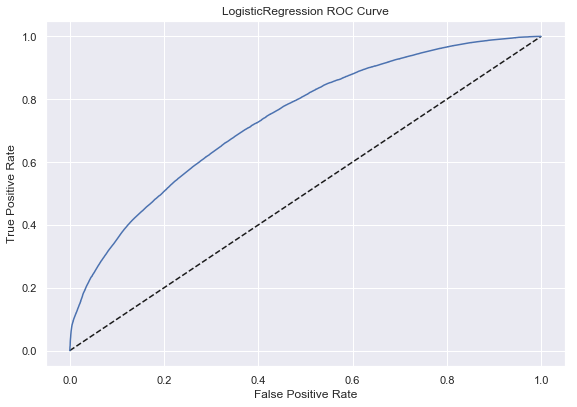

In [205]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_prob_scaled)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

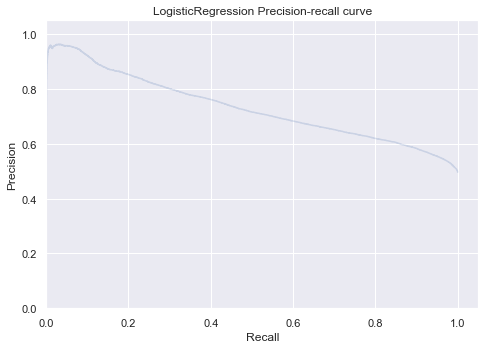

In [206]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve
y_score = model.decision_function(X_test_scaled)
precision, recall, _ = precision_recall_curve(y_test_scaled, y_score)
plt.step(recall, precision, color='b', alpha=0.2, where='post')

# formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("{} Precision-recall curve".format(model_name))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

### 3.2) KNeighborsClassifier

In [207]:
%%time
from sklearn.neighbors import KNeighborsClassifier 

# Create a k-NN classifier 
knn = KNeighborsClassifier()

# fit
knn.fit(X_train_scaled, y_train_scaled)

# Predict the labels for the training data X
y_pred_scaled = knn.predict(X_test_scaled)

Wall time: 2h 7min 37s


**Model performance**

In [208]:
model = knn
model_name = 'KNeighborsClassifier'

In [209]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test_scaled, y_test_scaled))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test_scaled, y_pred_scaled))

# Classification report
print("\nClassification report:\n", classification_report(y_test_scaled, y_pred_scaled))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test_scaled, y_pred_prob_scaled)))

# # Compute cross-validated AUC scores: cv_auc
# cv_auc = cross_val_score(model, X_scaled, y_scaled, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
# print("Mean AUC score: {}".format(np.mean(cv_auc)))

Score: 0.6873249312641854

Confusion matrix:
 [[93152 43377]
 [41347 93089]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.69    136529
           1       0.68      0.69      0.69    134436

   micro avg       0.69      0.69      0.69    270965
   macro avg       0.69      0.69      0.69    270965
weighted avg       0.69      0.69      0.69    270965


AUC: 0.7543140135037709
Wall time: 2h 48min 29s


### 3.3) DecisionTreeClassifier

In [207]:
%%time
from sklearn.tree import DecisionTreeClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=SEED)

# Fit dt to the training set
dt.fit(X_train,y_train) 

# Predict test set labels
y_pred = dt.predict(X_test)

Wall time: 2min 42s


**Model performance**

In [211]:
model = dt
model_name = 'DecisionTreeClassifier'

In [209]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# # Compute cross-validated AUC scores: cv_auc
# cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
# print("Mean AUC score: {}".format(np.mean(cv_auc)))

Score: 0.680353551196649

Confusion matrix:
 [[97087 39442]
 [47171 87265]]

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69    136529
           1       0.69      0.65      0.67    134436

   micro avg       0.68      0.68      0.68    270965
   macro avg       0.68      0.68      0.68    270965
weighted avg       0.68      0.68      0.68    270965


AUC: 0.7012288907925024
Wall time: 1.96 s


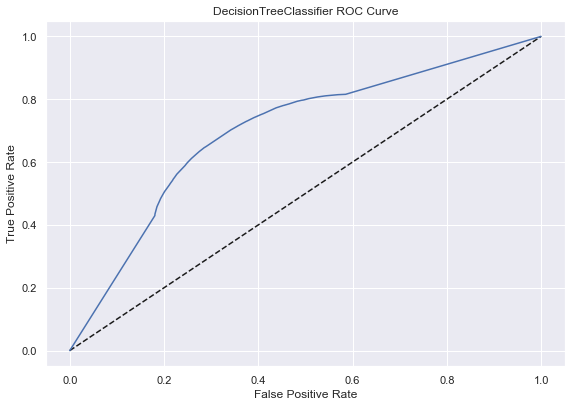

In [210]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### 3.4) BaggingClassifier

In [212]:
%%time

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, random_state=SEED)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

Wall time: 11min 34s


**Model performance**

In [213]:
model = bc
model_name = 'BaggingClassifier'

In [214]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# # Compute cross-validated AUC scores: cv_auc
# cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
# print("Mean AUC score: {}".format(np.mean(cv_auc)))

Score: 0.6930009410809514

Confusion matrix:
 [[96906 39623]
 [43563 90873]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    136529
           1       0.70      0.68      0.69    134436

   micro avg       0.69      0.69      0.69    270965
   macro avg       0.69      0.69      0.69    270965
weighted avg       0.69      0.69      0.69    270965


AUC: 0.7612989910939915
Wall time: 33 s


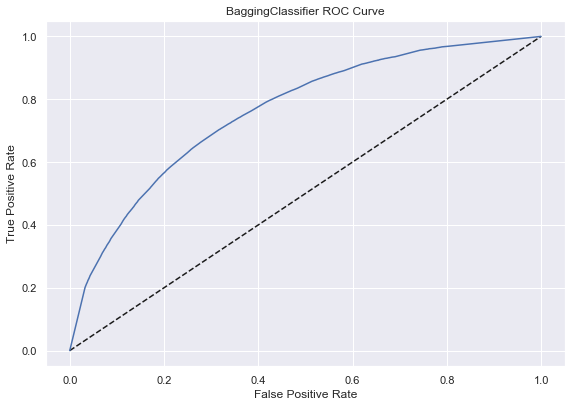

In [215]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### 3.5) AdaBoostClassifier

In [216]:
%%time
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, random_state=SEED)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Predict test set labels
y_pred = ada.predict(X_test)

Wall time: 39min 27s


**Model performance**

In [217]:
model = ada
model_name = 'AdaBoostClassifier'

In [218]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# # Compute cross-validated AUC scores: cv_auc
# cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
# print("Mean AUC score: {}".format(np.mean(cv_auc)))

Score: 0.6841215655158416

Confusion matrix:
 [[93518 43011]
 [42581 91855]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.69    136529
           1       0.68      0.68      0.68    134436

   micro avg       0.68      0.68      0.68    270965
   macro avg       0.68      0.68      0.68    270965
weighted avg       0.68      0.68      0.68    270965


AUC: 0.7238854823743603
Wall time: 12.2 s


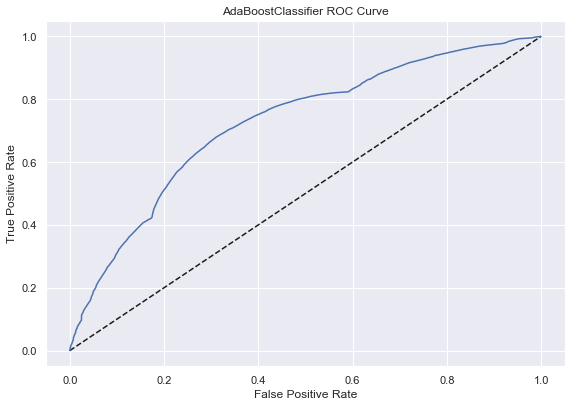

In [219]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### 3.6) RandomForestClassifier

In [207]:
%%time
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate ada
rf = RandomForestClassifier(n_estimators=10, random_state=SEED)

# Fit ada to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred = rf.predict(X_test)

Wall time: 2min 32s


**Model performance**

In [208]:
model = rf
model_name = 'RandomForestClassifier'

In [209]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


Score: 0.6944882180355396

Confusion matrix:
 [[97076 39453]
 [43330 91106]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    136529
           1       0.70      0.68      0.69    134436

   micro avg       0.69      0.69      0.69    270965
   macro avg       0.69      0.69      0.69    270965
weighted avg       0.69      0.69      0.69    270965


AUC: 0.7618833687969471
Wall time: 5.61 s


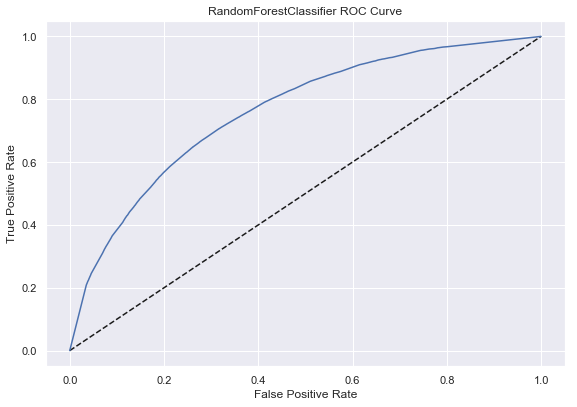

In [223]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### 3.7) GradientBoostingClassifier

In [224]:
%%time
# Import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate gbc
gbc = GradientBoostingClassifier(random_state=SEED)

# Fit ada to the training set
gbc.fit(X_train, y_train)

# Predict test set labels
y_pred = gbc.predict(X_test)

Wall time: 27min 6s


**Model performance**

In [225]:
model = gbc
model_name = 'GradientBoostingClassifier'

In [226]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


Score: 0.6703448784898418

Confusion matrix:
 [[89107 47422]
 [41903 92533]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.67    136529
           1       0.66      0.69      0.67    134436

   micro avg       0.67      0.67      0.67    270965
   macro avg       0.67      0.67      0.67    270965
weighted avg       0.67      0.67      0.67    270965


AUC: 0.7379323943895091
Wall time: 5.39 s


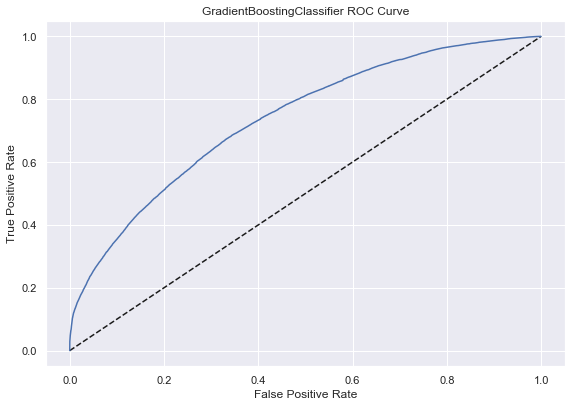

In [227]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

### 3.8) LinearSVC

In [228]:
%%time
from sklearn.svm import LinearSVC

# Instantiate
svm = LinearSVC()

# fit to the training set
svm.fit(X_train_scaled, y_train_scaled)

# Predict test set labels
y_pred_scaled = svm.predict(X_test_scaled)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Wall time: 7min 28s


**Model performance**

In [229]:
model = svm
model_name = 'LinearSVC'

In [230]:
%%time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test_scaled, y_test_scaled))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test_scaled, y_pred_scaled))

# Classification report
print("\nClassification report:\n", classification_report(y_test_scaled, y_pred_scaled))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test_scaled, y_pred_prob_scaled)))


Score: 0.6639935046961785

Confusion matrix:
 [[86344 50185]
 [40861 93575]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.65    136529
           1       0.65      0.70      0.67    134436

   micro avg       0.66      0.66      0.66    270965
   macro avg       0.66      0.66      0.66    270965
weighted avg       0.66      0.66      0.66    270965


AUC: 0.7369507293071405
Wall time: 1.31 s


### 3.11) SGDClassifier

In [232]:
%%time

from sklearn.linear_model import SGDClassifier

# Instantiate
linear_classifier = SGDClassifier(random_state=SEED)

# fit to the training set
linear_classifier.fit(X_train_scaled, y_train_scaled)

# Predict test set labels
y_pred = linear_classifier.predict(X_test_scaled)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Wall time: 5.44 s


**Model performance**

In [233]:
model = linear_classifier
model_name = 'SGDClassifier'

In [235]:
%%time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test_scaled, y_test_scaled))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test_scaled, y_pred_scaled))

# Classification report
print("\nClassification report:\n", classification_report(y_test_scaled, y_pred_scaled))

#####################################################

# # Compute predicted probabilities: y_pred_prob
# y_pred_prob_scaled = model.predict_proba(X_test_scaled)[:, 1]

# # Compute and print AUC score
# print("\nAUC: {}".format(roc_auc_score(y_test_scaled, y_pred_prob_scaled)))


Score: 0.6497997896407285

Confusion matrix:
 [[86344 50185]
 [40861 93575]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.65    136529
           1       0.65      0.70      0.67    134436

   micro avg       0.66      0.66      0.66    270965
   macro avg       0.66      0.66      0.66    270965
weighted avg       0.66      0.66      0.66    270965

Wall time: 1.07 s


## Model results comparison

#### Summary:

#### All variables 

| Model                      |  Score (Accuracy) | Precision  | Recall  | f1-score | AUC score |
| -------------------        |:-----------------:| -----------|:-----:  | :-------:|:-------:
| LogisticRegression         |       0.666       | 0.67       | 0.67    |  0.66    | 0.737
| KNeighborsClassifier       |       0.687       | **0.69**   | **0.69**| **0.69** | 0.754
| DecisionTreeClassifier     |       0.680       | 0.68       | 0.68    |  0.68    | 0.701
| BaggingClassifier          |       0.693       | **0.69**   | **0.69**| **0.69** | 0.761      
| AdaBoostClassifier         |       0.684       | 0.68       | 0.68    |  0.68    | 0.724
| **RandomForestClassifier** |       **0.694**   | **0.69**   | **0.69**| **0.69** | **0.762**
| GradientBoostingClassifier |       0.670       | 0.67       | 0.67    |  0.67    | 0.738
| LinearSVC                  |       0.664       | 0.66       | 0.66    |  0.66    | 0.737
| SGDClassifier              |       0.650       | 0.66       | 0.66    |  0.66    | 0.      



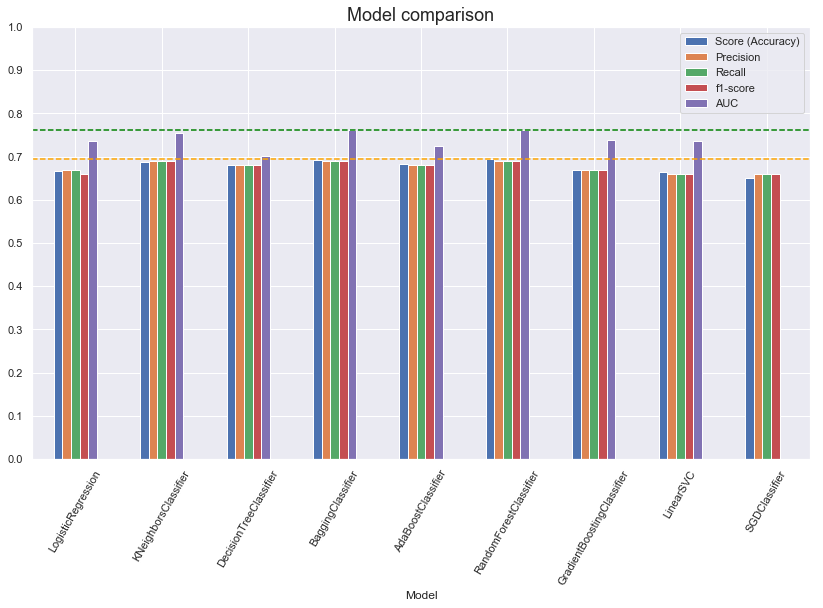

In [238]:
# individual results
r_logreg = np.array([0.666, 0.67, 0.67, 0.66, 0.737])
r_knn = np.array([0.687, 0.69, 0.69, 0.69, 0.754])
r_dt = np.array([0.680, 0.68, 0.68, 0.68, 0.701])
r_bc = np.array([0.693, 0.69, 0.69, 0.69, 0.761])
r_ada = np.array([0.684, 0.68, 0.68, 0.68, 0.724])
r_rf = np.array([0.694, 0.69, 0.69, 0.69, 0.762])
r_gbc = np.array([0.670, 0.67, 0.67, 0.67, 0.738])
r_svm = np.array([0.664, 0.66, 0.66, 0.66, 0.737])
r_sgd = np.array([0.650, 0.66, 0.66, 0.66, 0])

r_columns = ['Score (Accuracy)', 'Precision', 'Recall', 'f1-score', 'AUC']
r_index = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'BaggingClassifier',
          'AdaBoostClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'LinearSVC', 'SGDClassifier']

results = pd.DataFrame(np.row_stack([r_logreg, r_knn, r_dt, r_bc, r_ada, r_rf, r_gbc, r_svm, r_sgd]), 
                       index=r_index, columns=r_columns)

# pd.DataFrame(list(zip(r_logreg, r_knn, r_dt, r_bc, r_ada, r_rf, r_gbc, r_svm, r_sgd)), index=r_columns, columns=r_index)

# plot
results.plot(kind='bar')

# formatting
plt.title("Model comparison", fontsize=18)
plt.xlabel("Model")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(y=np.max(results['AUC']), c='green', linestyle='--')
plt.axhline(y=np.max(results[['Score (Accuracy)', 'Precision', 'Recall', 'f1-score']]).max(), c='orange', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=60)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.8, top=1, wspace=0, hspace=0)
plt.show()

## 4) Dimension reduction & Feature selection
<a id="dim_red"></a>

#### t-SNE

In [238]:
%%script false

%%time

# Fitting t-SNE
from sklearn.manifold import TSNE

m = TSNE(learning_rate=100)

X_tsne = X[:, mask].copy()

tsne_features = m.fit_transform(X_tsne)

X_tsne_df = pd.DataFrame(data=X_tsne)

# Assigning t-SNE features to our dataset
X_tsne_df['x'] = tsne_features[:,0]
X_tsne_df['y'] = tsne_features[:,1]


Couldn't find program: 'false'


In [ ]:
%%script false

%%time
# plot
sns.scatterplot(x="x", y="y", data=X_tsne_df)
plt.title("t-SNE applied to the dataset")
plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0, hspace=0)
plt.show()

Computer memory couldn't handle this.

#### Number of features to consider

In [211]:
n_features = 100

#### Recursive Feature Elimination with the RandomForestClassifier

In [212]:
%%time

# feature selection with RFE and RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

SEED = 10
steps = 10

# Recursive Feature Elimination
rfe = RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=SEED), 
          n_features_to_select=n_features, 
          step=steps,
          verbose=1)

# fit
rfe.fit(X_train, y_train)

# predict
y_pred = rfe.predict(X_test)

print("\n With {} features, new score using RFE: {}".format(n_features, accuracy_score(y_test, y_pred)))


Fitting estimator with 202 features.
Fitting estimator with 192 features.
Fitting estimator with 182 features.
Fitting estimator with 172 features.
Fitting estimator with 162 features.
Fitting estimator with 152 features.
Fitting estimator with 142 features.
Fitting estimator with 132 features.
Fitting estimator with 122 features.
Fitting estimator with 112 features.
Fitting estimator with 102 features.

 With 100 features, new score using RFE: 0.6922296237521451
Wall time: 19min 16s


In [213]:
model = rfe
model_name = 'RFE with RandomForestClassifier'

In [214]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


Score: 0.6922296237521451

Confusion matrix:
 [[96906 39623]
 [43772 90664]]

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70    136529
           1       0.70      0.67      0.68    134436

   micro avg       0.69      0.69      0.69    270965
   macro avg       0.69      0.69      0.69    270965
weighted avg       0.69      0.69      0.69    270965


AUC: 0.7590651587564907
Wall time: 7.4 s


The performance is just slightly worse. I tried with a number of features equal to 85, 100, 110, 150 and the best performance was with 100 features, but still not as good as when we have all the 202 features. My computer memory could not handle EDA with all the variables, so I do it after this initial feature selection just to see the corresponding variances of each feature from that perspective.

In [215]:
# mask
mask = rfe.support_

# Applying the mask to the feature dataset
reduced_X = non_linear_df.drop('real_time_class', axis=1).loc[:, mask]

print("\nReduced X: ({} features)\n {}".format(n_features, reduced_X.columns), "\n")

# ranking
# print(dict(zip(non_linear_df.drop('real_time_class', axis=1).columns, rfe.ranking_)))


Reduced X: (100 features)
 Index(['loan_amount', 'lender_term', 'num_lenders_total',
       'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing',
       'sector_name_Construction', 'sector_name_Education', 'sector_name_Food',
       'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal Use',
       'sector_name_Retail', 'sector_name_Services',
       'sector_name_Transportation', 'country_name_Azerbaijan',
       'country_name_Benin', 'country_name_Bolivia', 'country_name_Cambodia',
       'country_name_Colombia', 'country_name_Ecuador',
       'country_name_El Salvador', 'country_name_Ghana',
       'country_name_Guatemala', 'country_name_Honduras',
       'country_name_Indonesia', 'country_name_Kenya',
       'country_name_Kyrgyzstan', 'country_name_Lebanon',
       'country_name_Madagascar', 'country_name_Mali', 'country_name_Mexico',
       'country_name_Nicaragua', 'country_name_Nigeria',
       'country_name_Parag

#### Variance of the PCA features

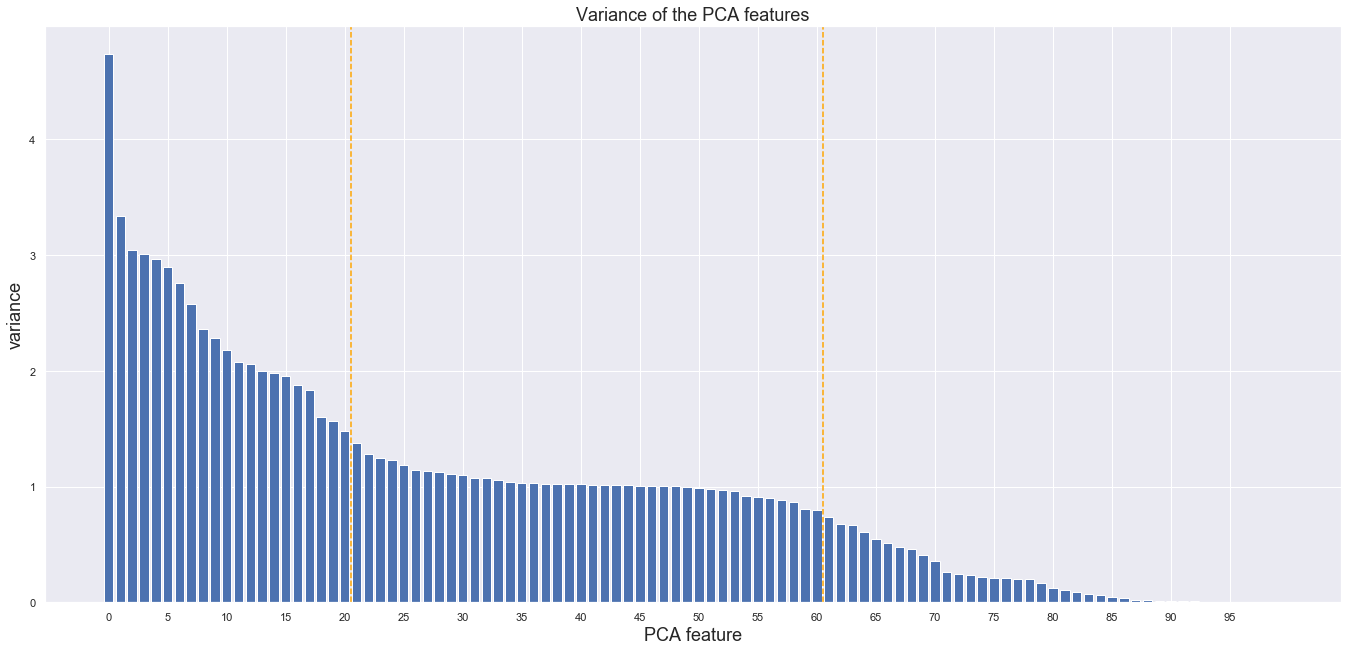

Wall time: 33.1 s


In [223]:
%%time

# scaling the features
X_pca = scale(X[:, mask])  

# Initialize a new PCA model with the default number of components.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_pca)

# features
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)

# formatting
plt.title("Variance of the PCA features", fontsize=18)
plt.xlabel('PCA feature', fontsize=18)
plt.ylabel('variance', fontsize=18)
plt.xticks(np.arange(0, n_features, 5))
plt.axvline(x=20.5, c='orange', linestyle='--')
plt.axvline(x=60.5, c='orange', linestyle='--')

plt.subplots_adjust(left=0, bottom=-1, right=3, top=1, wspace=0, hspace=0)
plt.show()

**With 100 features**, we see that the explained variance starts to decrease rapidly after approximately 60 features. However, we got better model performance with all the variables.

In [218]:
pca_n_components = n_features

In [219]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(n_components=pca_n_components)), 
                 ('classifier', RandomForestClassifier(n_estimators=10))])

pipe.fit(X_train, y_train)

print(pipe.steps[1])  # [0] é o scaler, [1] o PCA e [2] o modelo

print("\nExplained_variance_ratio_ cumulative sum:", pipe.steps[1][1].explained_variance_ratio_.cumsum())

print("\nScore:", pipe.score(X_test, y_test))

('reducer', PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))

Explained_variance_ratio_ cumulative sum: [0.02484538 0.04271999 0.05929367 0.07539829 0.09112008 0.10675606
 0.12206662 0.13730676 0.15241721 0.16743383 0.18238347 0.19729996
 0.21207465 0.2266461  0.24114695 0.25553909 0.26991017 0.28395813
 0.297906   0.31169514 0.32508366 0.33823468 0.35128984 0.36426806
 0.37710351 0.38851391 0.39914395 0.40970263 0.4196653  0.42961469
 0.43954991 0.4494574  0.45931535 0.46911673 0.47885132 0.48852332
 0.49817008 0.50761372 0.51699851 0.52607592 0.53492852 0.5435203
 0.55195536 0.56004093 0.56762235 0.57476576 0.58169961 0.58813359
 0.59435517 0.60044257 0.60634513 0.61216534 0.61785237 0.62341563
 0.62896778 0.63447239 0.63983813 0.64516462 0.65046576 0.65571845
 0.66092323 0.66610378 0.67125041 0.67635957 0.68146062 0.68652667
 0.69157883 0.69661185 0.70164124 0.70665997 0.71167381 0.71667891
 0.72168054 0.72668086

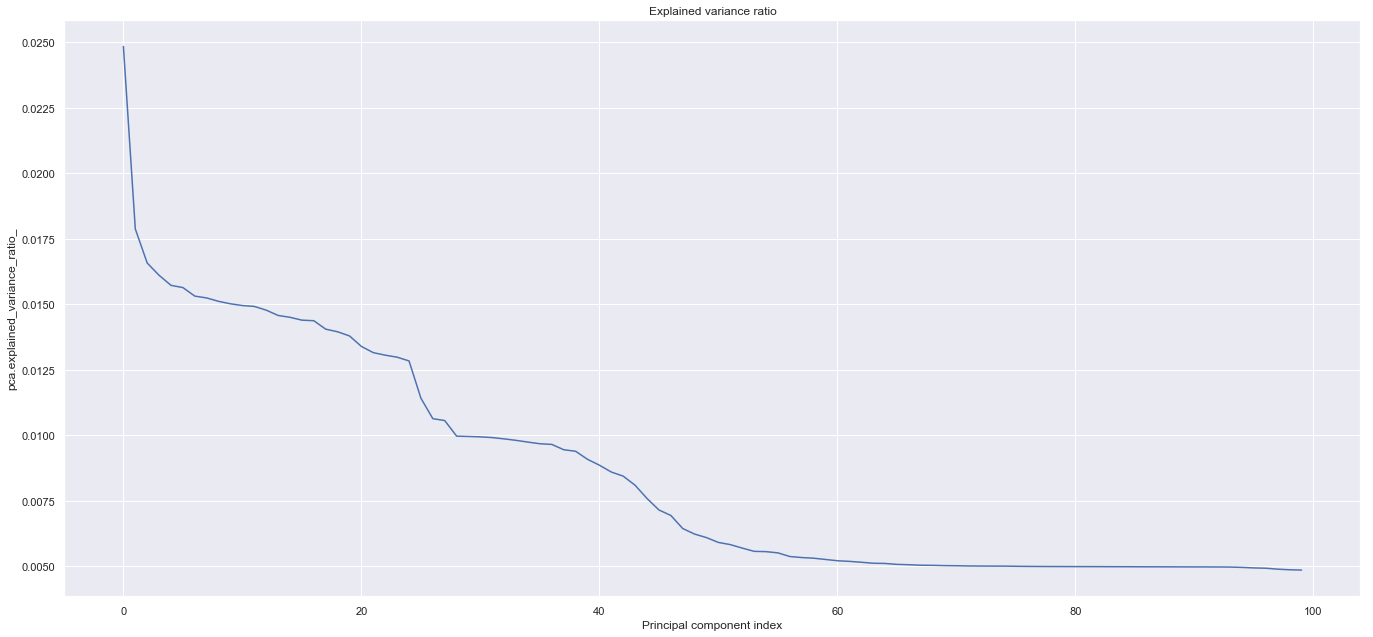

In [220]:
# An optimal number of components
var = pipe.steps[1][1].explained_variance_ratio_

plt.plot(var)

plt.title("Explained variance ratio")
plt.xlabel('Principal component index')
plt.ylabel('pca.explained_variance_ratio_')

plt.subplots_adjust(left=0, bottom=-1, right=3, top=1, wspace=0, hspace=0)
plt.show()

#### Visualizing feature importances - single model, not tuned

In [237]:
# model
model = rf
model_name = 'RandomForestClassifier'

Considering the **RandomForestClassifier**, the model which gave the best performance, we can grasp at the most relevant features, which gave the model higher information gain when processing.

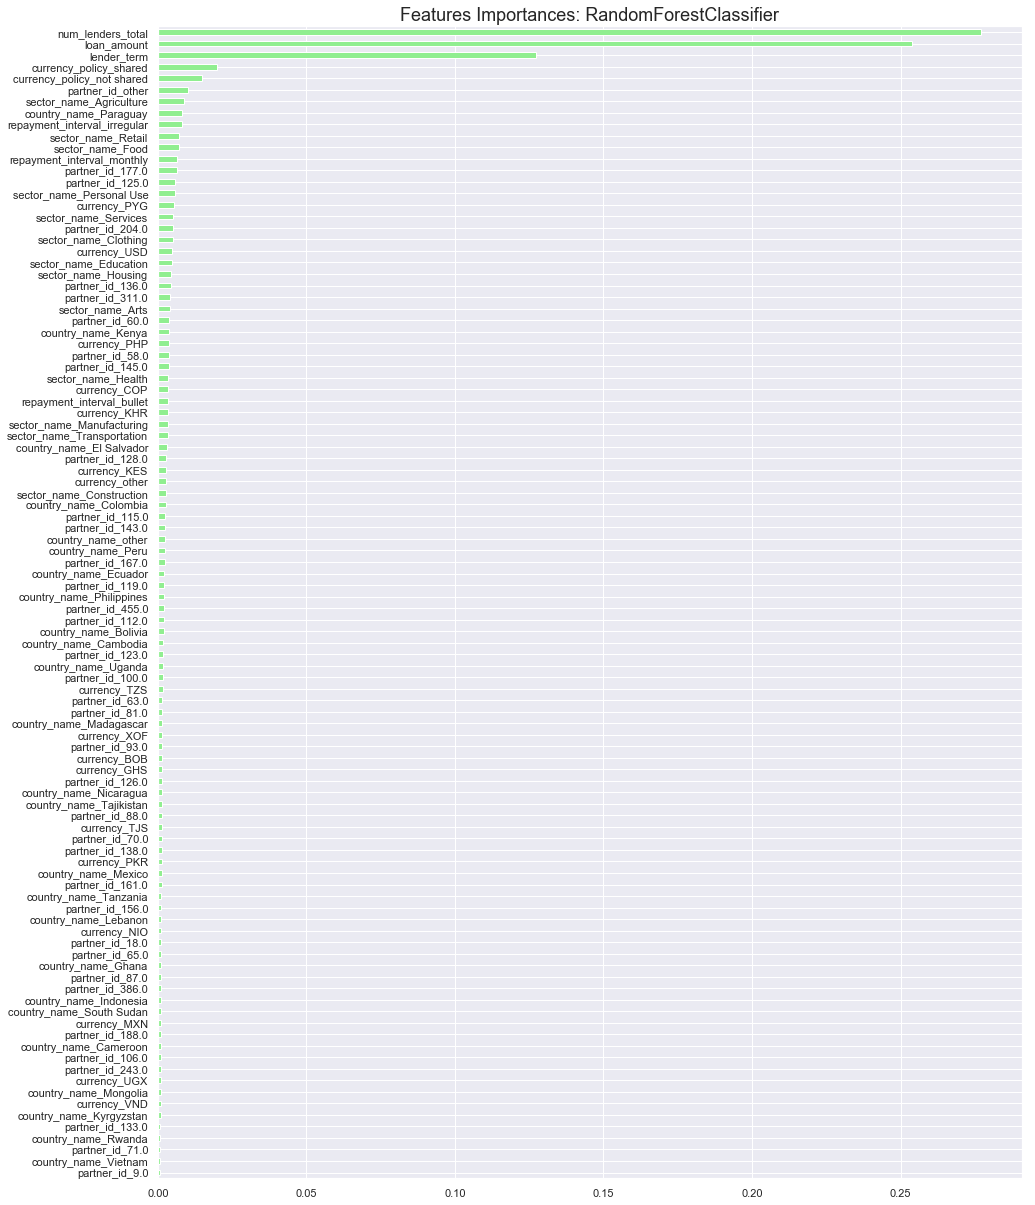

In [225]:
# Create a pd.Series of features importances
importances = pd.Series(data=model.feature_importances_, index=non_linear_df.drop('real_time_class', axis=1).columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('Features Importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-3, right=2, top=1, wspace=0, hspace=0)
plt.show()

In [226]:
# relevant_variables
relevant_variables = importances_sorted.tail(n_features).index

print("{} Most important features running the {} once: \n\n{}".format(n_features, model_name, relevant_variables))

100 Most important features running the RandomForestClassifier once: 

Index(['partner_id_9.0', 'country_name_Vietnam', 'partner_id_71.0',
       'country_name_Rwanda', 'partner_id_133.0', 'country_name_Kyrgyzstan',
       'currency_VND', 'country_name_Mongolia', 'currency_UGX',
       'partner_id_243.0', 'partner_id_106.0', 'country_name_Cameroon',
       'partner_id_188.0', 'currency_MXN', 'country_name_South Sudan',
       'country_name_Indonesia', 'partner_id_386.0', 'partner_id_87.0',
       'country_name_Ghana', 'partner_id_65.0', 'partner_id_18.0',
       'currency_NIO', 'country_name_Lebanon', 'partner_id_156.0',
       'country_name_Tanzania', 'partner_id_161.0', 'country_name_Mexico',
       'currency_PKR', 'partner_id_138.0', 'partner_id_70.0', 'currency_TJS',
       'partner_id_88.0', 'country_name_Tajikistan', 'country_name_Nicaragua',
       'partner_id_126.0', 'currency_GHS', 'currency_BOB', 'partner_id_93.0',
       'currency_XOF', 'country_name_Madagascar', 'partner_id

In [227]:
# RFE features - just to check, are there very different?
print("\nReduced X: ({} features)\n {}".format(n_features, reduced_X.columns), "\n")


Reduced X: (100 features)
 Index(['loan_amount', 'lender_term', 'num_lenders_total',
       'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing',
       'sector_name_Construction', 'sector_name_Education', 'sector_name_Food',
       'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal Use',
       'sector_name_Retail', 'sector_name_Services',
       'sector_name_Transportation', 'country_name_Azerbaijan',
       'country_name_Benin', 'country_name_Bolivia', 'country_name_Cambodia',
       'country_name_Colombia', 'country_name_Ecuador',
       'country_name_El Salvador', 'country_name_Ghana',
       'country_name_Guatemala', 'country_name_Honduras',
       'country_name_Indonesia', 'country_name_Kenya',
       'country_name_Kyrgyzstan', 'country_name_Lebanon',
       'country_name_Madagascar', 'country_name_Mali', 'country_name_Mexico',
       'country_name_Nicaragua', 'country_name_Nigeria',
       'country_name_Parag

In [229]:
# intersection
len(np.intersect1d(relevant_variables, reduced_X.columns))

87

**PermutationImportance**

In [219]:
%%script false

%%time
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 10).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)

Computer memory couldn't handle this.

## 5) Hyperparameter Tuning
<a id="tuning"></a>

### RandomForestClassifier

In [218]:
%%time
from sklearn.model_selection import GridSearchCV

# we will use all the parameters
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)

# Set the hyperparameter grid of rf
params_rf = {'criterion': ['gini', 'entropy'], 
             'min_samples_leaf':[1, 2],
             'max_features':['auto', 'log2']}

# GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1)

# Fit to the training set
grid_rf.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2}
Wall time: 2h 2min 3s


**Model performance**

In [223]:
model = grid_rf
model_name = 'Tuned RandomForestClassifier'

In [225]:
%%time
# Extract best model
best_model = model.best_estimator_

# Predict the test set labels
y_pred = best_model.predict(X_test)

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


Score: 0.702526156514679

Confusion matrix:
 [[96879 39650]
 [40955 93481]]

Classification report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.71    136529
           1       0.70      0.70      0.70    134436

   micro avg       0.70      0.70      0.70    270965
   macro avg       0.70      0.70      0.70    270965
weighted avg       0.70      0.70      0.70    270965


AUC: 0.7787337700055688
Wall time: 49.3 s


In [234]:
grid_rf.cv_results_

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([ 938.57283537,  918.84724704,  904.68989841,  811.16370551,
        1023.18798296,  951.41637238,  923.72166594,  797.02905504]),
 'std_fit_time': array([ 7.87346769, 35.74728982,  7.28935967,  4.47128887,  6.64897475,
        16.38474332, 23.70406594, 22.60688101]),
 'mean_score_time': array([106.27082109,  48.19744849,  89.51445365,  51.22308962,
         92.45044676,  47.34206613,  81.26042898,  58.31128343]),
 'std_score_time': array([ 4.56372642, 11.71046129, 14.13306928,  7.57806034, 17.09539653,
         7.80109783,  1.58484025,  4.49008928]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy', 'entropy'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'auto', 'log2', 'log2', 'auto', 'auto', 'log2',
                    'log2'],
              mask=[False,

**Further tuning**

In [221]:
%%time
from sklearn.model_selection import GridSearchCV

# we will use all the parameters
rf_new = RandomForestClassifier(min_samples_leaf=4, random_state=SEED)

# Set the hyperparameter grid of rf
params_rf_new = {'n_estimators': [400, 200]}  

# GridSearchCV
grid_rf_new = GridSearchCV(estimator=rf_new, param_grid=params_rf_new, cv=3, n_jobs=-1)

# Fit to the training set
grid_rf_new.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = grid_rf_new.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'n_estimators': 400}
Wall time: 2h 5min 54s


**Model performance**

In [222]:
model = grid_rf_new
model_name = 'Tuned RandomForestClassifier'

In [223]:
%%time
# Extract best model
best_model = model.best_estimator_

# Predict the test set labels
y_pred_new = best_model.predict(X_test)

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_new))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred_new))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob_new = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob_new)))


Score: 0.7072573948664956

Confusion matrix:
 [[97436 39093]
 [40230 94206]]

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71    136529
           1       0.71      0.70      0.70    134436

   micro avg       0.71      0.71      0.71    270965
   macro avg       0.71      0.71      0.71    270965
weighted avg       0.71      0.71      0.71    270965


AUC: 0.7848423591048038
Wall time: 2min 17s


#### Final Model

In [202]:
%%time
from sklearn.ensemble import RandomForestClassifier

# final rf
rf_final = RandomForestClassifier(n_estimators=400, min_samples_leaf=4, random_state=SEED)

# Fit to the training set
rf_final.fit(X_train, y_train)

# Predict test set labels
y_pred_final = rf_final.predict(X_test)

Wall time: 1h 29min 20s


In [203]:
model = rf_final
model_name = 'Tuned RandomForestClassifier'

In [204]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_final))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred_final))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


Score: 0.7237761334489694

Confusion matrix:
 [[99106 37423]
 [37424 97012]]

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73    136529
           1       0.72      0.72      0.72    134436

   micro avg       0.72      0.72      0.72    270965
   macro avg       0.72      0.72      0.72    270965
weighted avg       0.72      0.72      0.72    270965


AUC: 0.8046943497441834
Wall time: 1min 39s


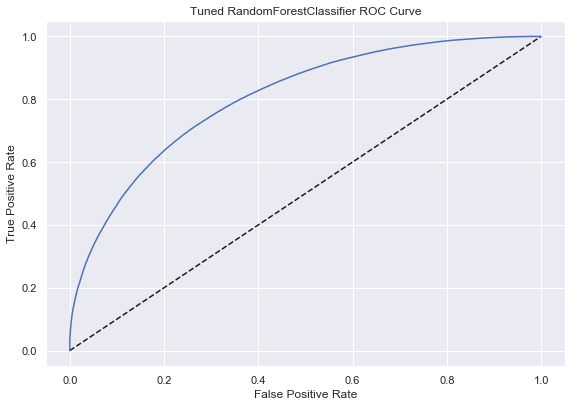

Wall time: 49 s


In [205]:
%%time
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of the labels of the test set (X_test): y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("{} ROC Curve".format(model_name))
plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0, hspace=0)
plt.show()

## 6) Conclusion
<a id="conclusion"></a>

#### Feature importances

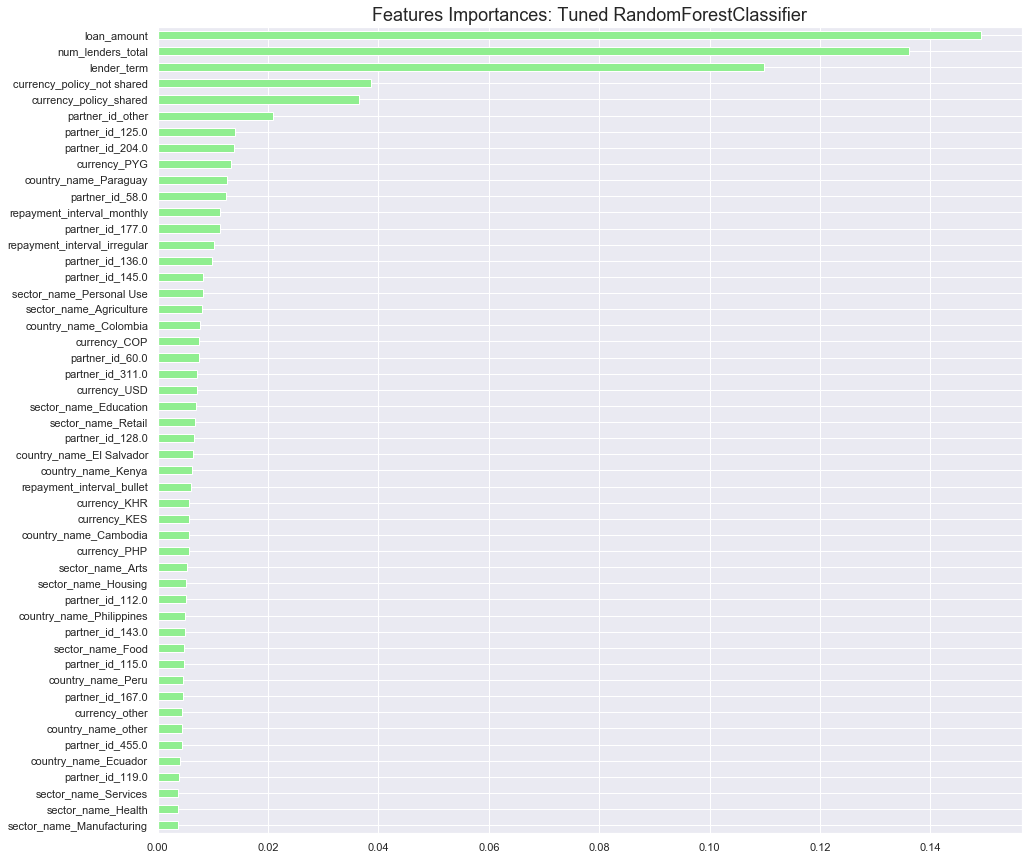

In [214]:
# Create a pd.Series of features importances
importances = pd.Series(data=model.feature_importances_, index=non_linear_df.drop('real_time_class', axis=1).columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.tail(50).plot(kind='barh', color='lightgreen')
plt.title('Features Importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-1.8, right=2, top=1, wspace=0, hspace=0)
plt.show()

We see that the amount of the loan ('loan_amount'), the total number of lenders ('num_lenders_total'), the lender term ('lender_term') and the currency policy ('currency_policy') are the most relevant features when predicting if a loan will be classified as one with a higher delay or not. Some of these are correlated, as we have seen.

We can take a further look at the 30 most important features, according to our model. They represent a cumulative importance of 70%.

In [215]:
# cumulative importance
cum_imp_30 = importances.sort_values(ascending=False)[:30]
cum_imp_30.sum()

0.7062409399202905

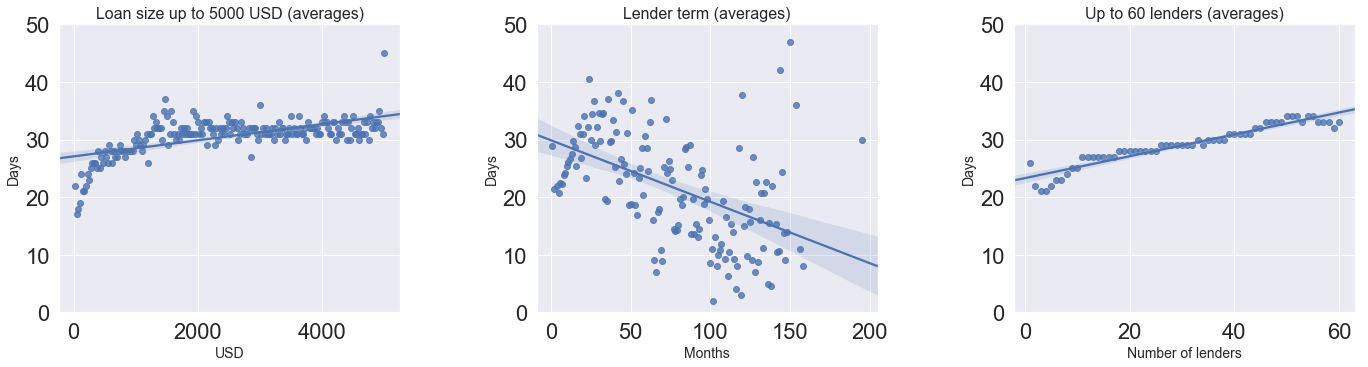

In [222]:
# plots of the 30 most important features

# non-dummy variables

# loan_amount
plt.subplot(1, 3, 1)
sns.regplot(x='loan_amount_size_5000', y='avg_time_loan_5000', data=loan_amount_time_5000)
plt.title("Loan size up to 5000 USD (averages)", fontsize=16)
plt.xlabel("USD", fontsize=14)
plt.ylabel("Days", fontsize=14)
plt.ylim(0, 50)

# lender_term
plt.subplot(1, 3, 2)
sns.regplot(x='lender_term_i', y='avg_time_lender_term', data=time_lender_term)
plt.title("Lender term (averages)", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Days", fontsize=14)
plt.ylim(0, 50)

# num_lenders_total
plt.subplot(1, 3, 3)
sns.regplot(x='loan_numlend_60', y='avg_time_numlend_60', data=loan_numlend_time_60)
plt.title("Up to 60 lenders (averages)", fontsize=16)
plt.xlabel("Number of lenders", fontsize=14)
plt.ylabel("Days", fontsize=14)
plt.ylim(0, 50)
    
plt.subplots_adjust(left=0, bottom=0, right=3, top=1, wspace=0.4, hspace=0.5)
plt.show() 

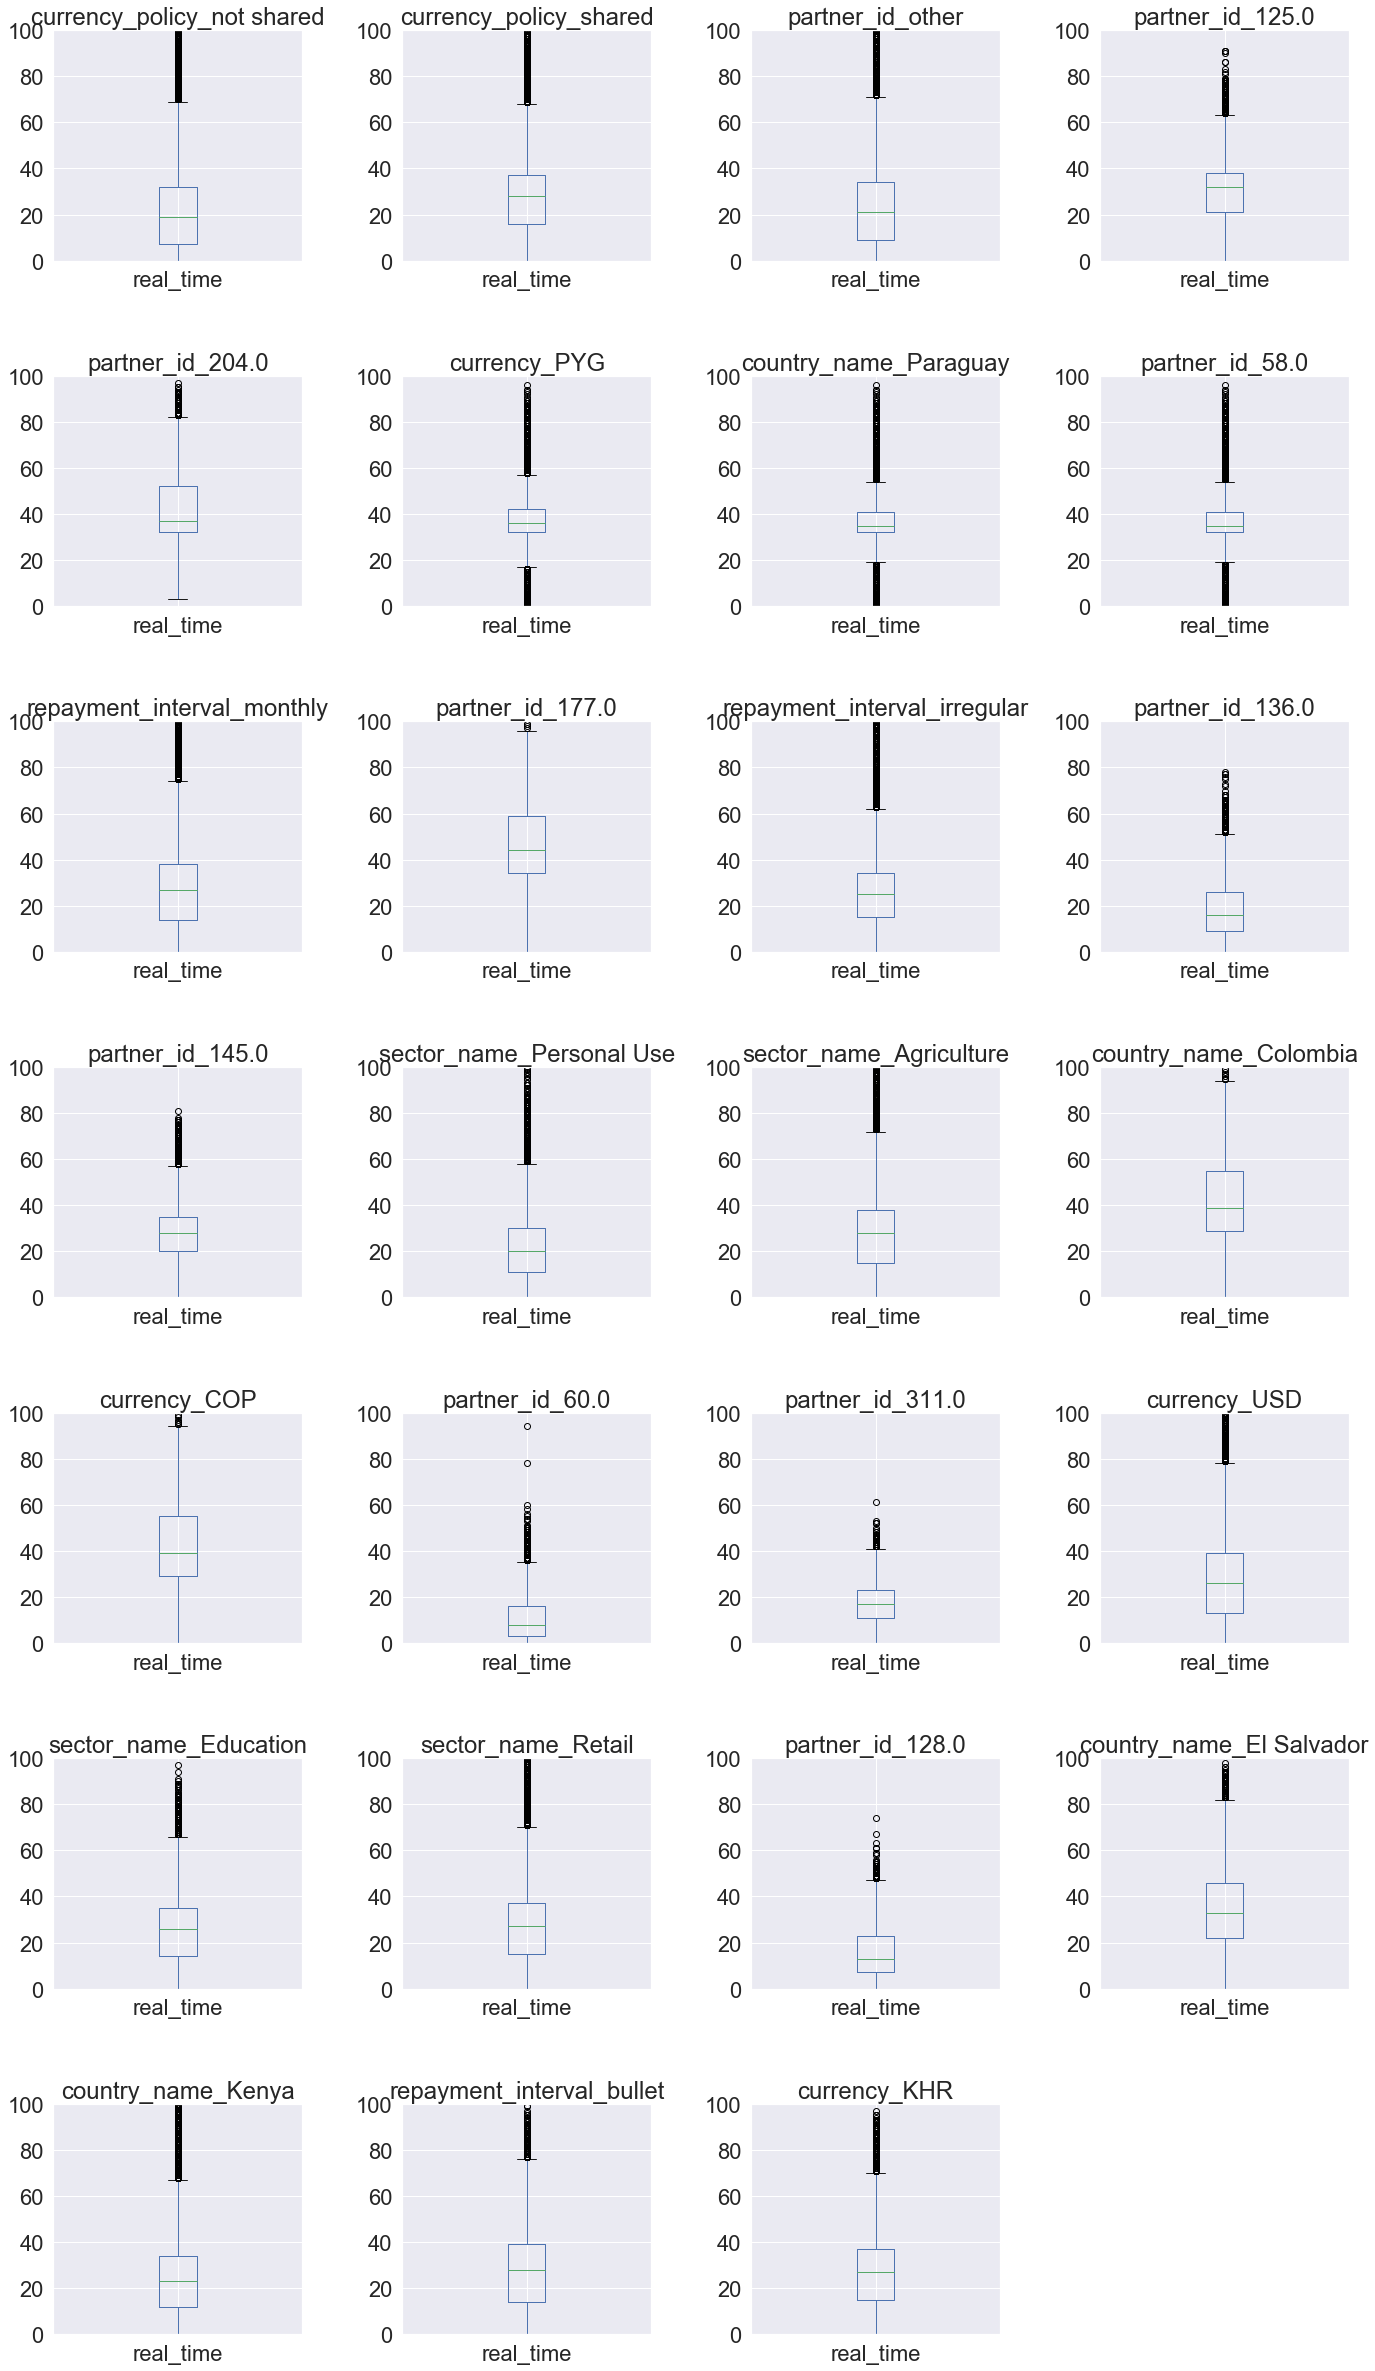

In [220]:
sns.set(font_scale=2)

# boxplot for the dummy variables
for i, j in enumerate(list(cum_imp_30.index)[3:]):
    plt.subplot(7, 4, i+1)
    index_wanted = non_linear_df[non_linear_df[j] == 1].index
    plt.title(j)
    plt.ylim(0, 100)
    final_df.iloc[index_wanted].real_time.plot(kind='box')

plt.subplots_adjust(left=0, bottom=-7, right=3, top=1, wspace=0.4, hspace=0.5)
plt.show() 

When relating to the previous EDA made, we see that some features are more helpful to predict when a loan will be delayed more than the desirable time, others to when it will have a smaller delay. For instance, we see that the the 2 most important ones (loan_amount and num_lenders_total), which are positively correlated as we have also seen earlier, help the model in the sense that they contribute to higher delayed loans. Or, for instance, if it is a loan for Paraguay. Any loan with a high value in these features will be a motive of concern from the start, in the sense that they are good indicators of a higher delay. On the other hand, if, for instance, the loan has a shared currency policy, or it belongs to the 'Personal Use' sector, or the partner id is nº136, these are all good indicators that the model will be funded "on time". 

We see that one of the most important features came up to be a product of our initial feature extraction, namely 'partner_id_other', which represents 15% of the data and 379 partners. Although each one has a small representation on the totality of loans, in this case it joined loans that, when seen as a whole, are not related with higher delays:

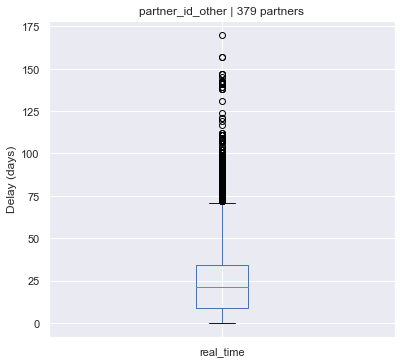

In [219]:
index_other = non_linear_df[non_linear_df['partner_id_other'] == 1].index

# boxplot
final_df.iloc[index_other].real_time.plot(kind='box')

plt.title("partner_id_other | 379 partners")
plt.ylabel("Delay (days)")
plt.subplots_adjust(left=0, bottom=-0.1, right=0.8, top=1, wspace=0, hspace=0)
plt.show()

We should also look at the correlation between these important variables, before thinking if a loan with this or that feature may be problematic. These importances might hide the fact that a cause of a delay in a loan can have origin on one or few variables, but when other variables are highly correlated with those they will appear as "important" as well.

In [224]:
# cumulative importance
cum_imp_15 = importances.sort_values(ascending=False)[:15]
cum_imp_15.sum()

0.5998522054142157

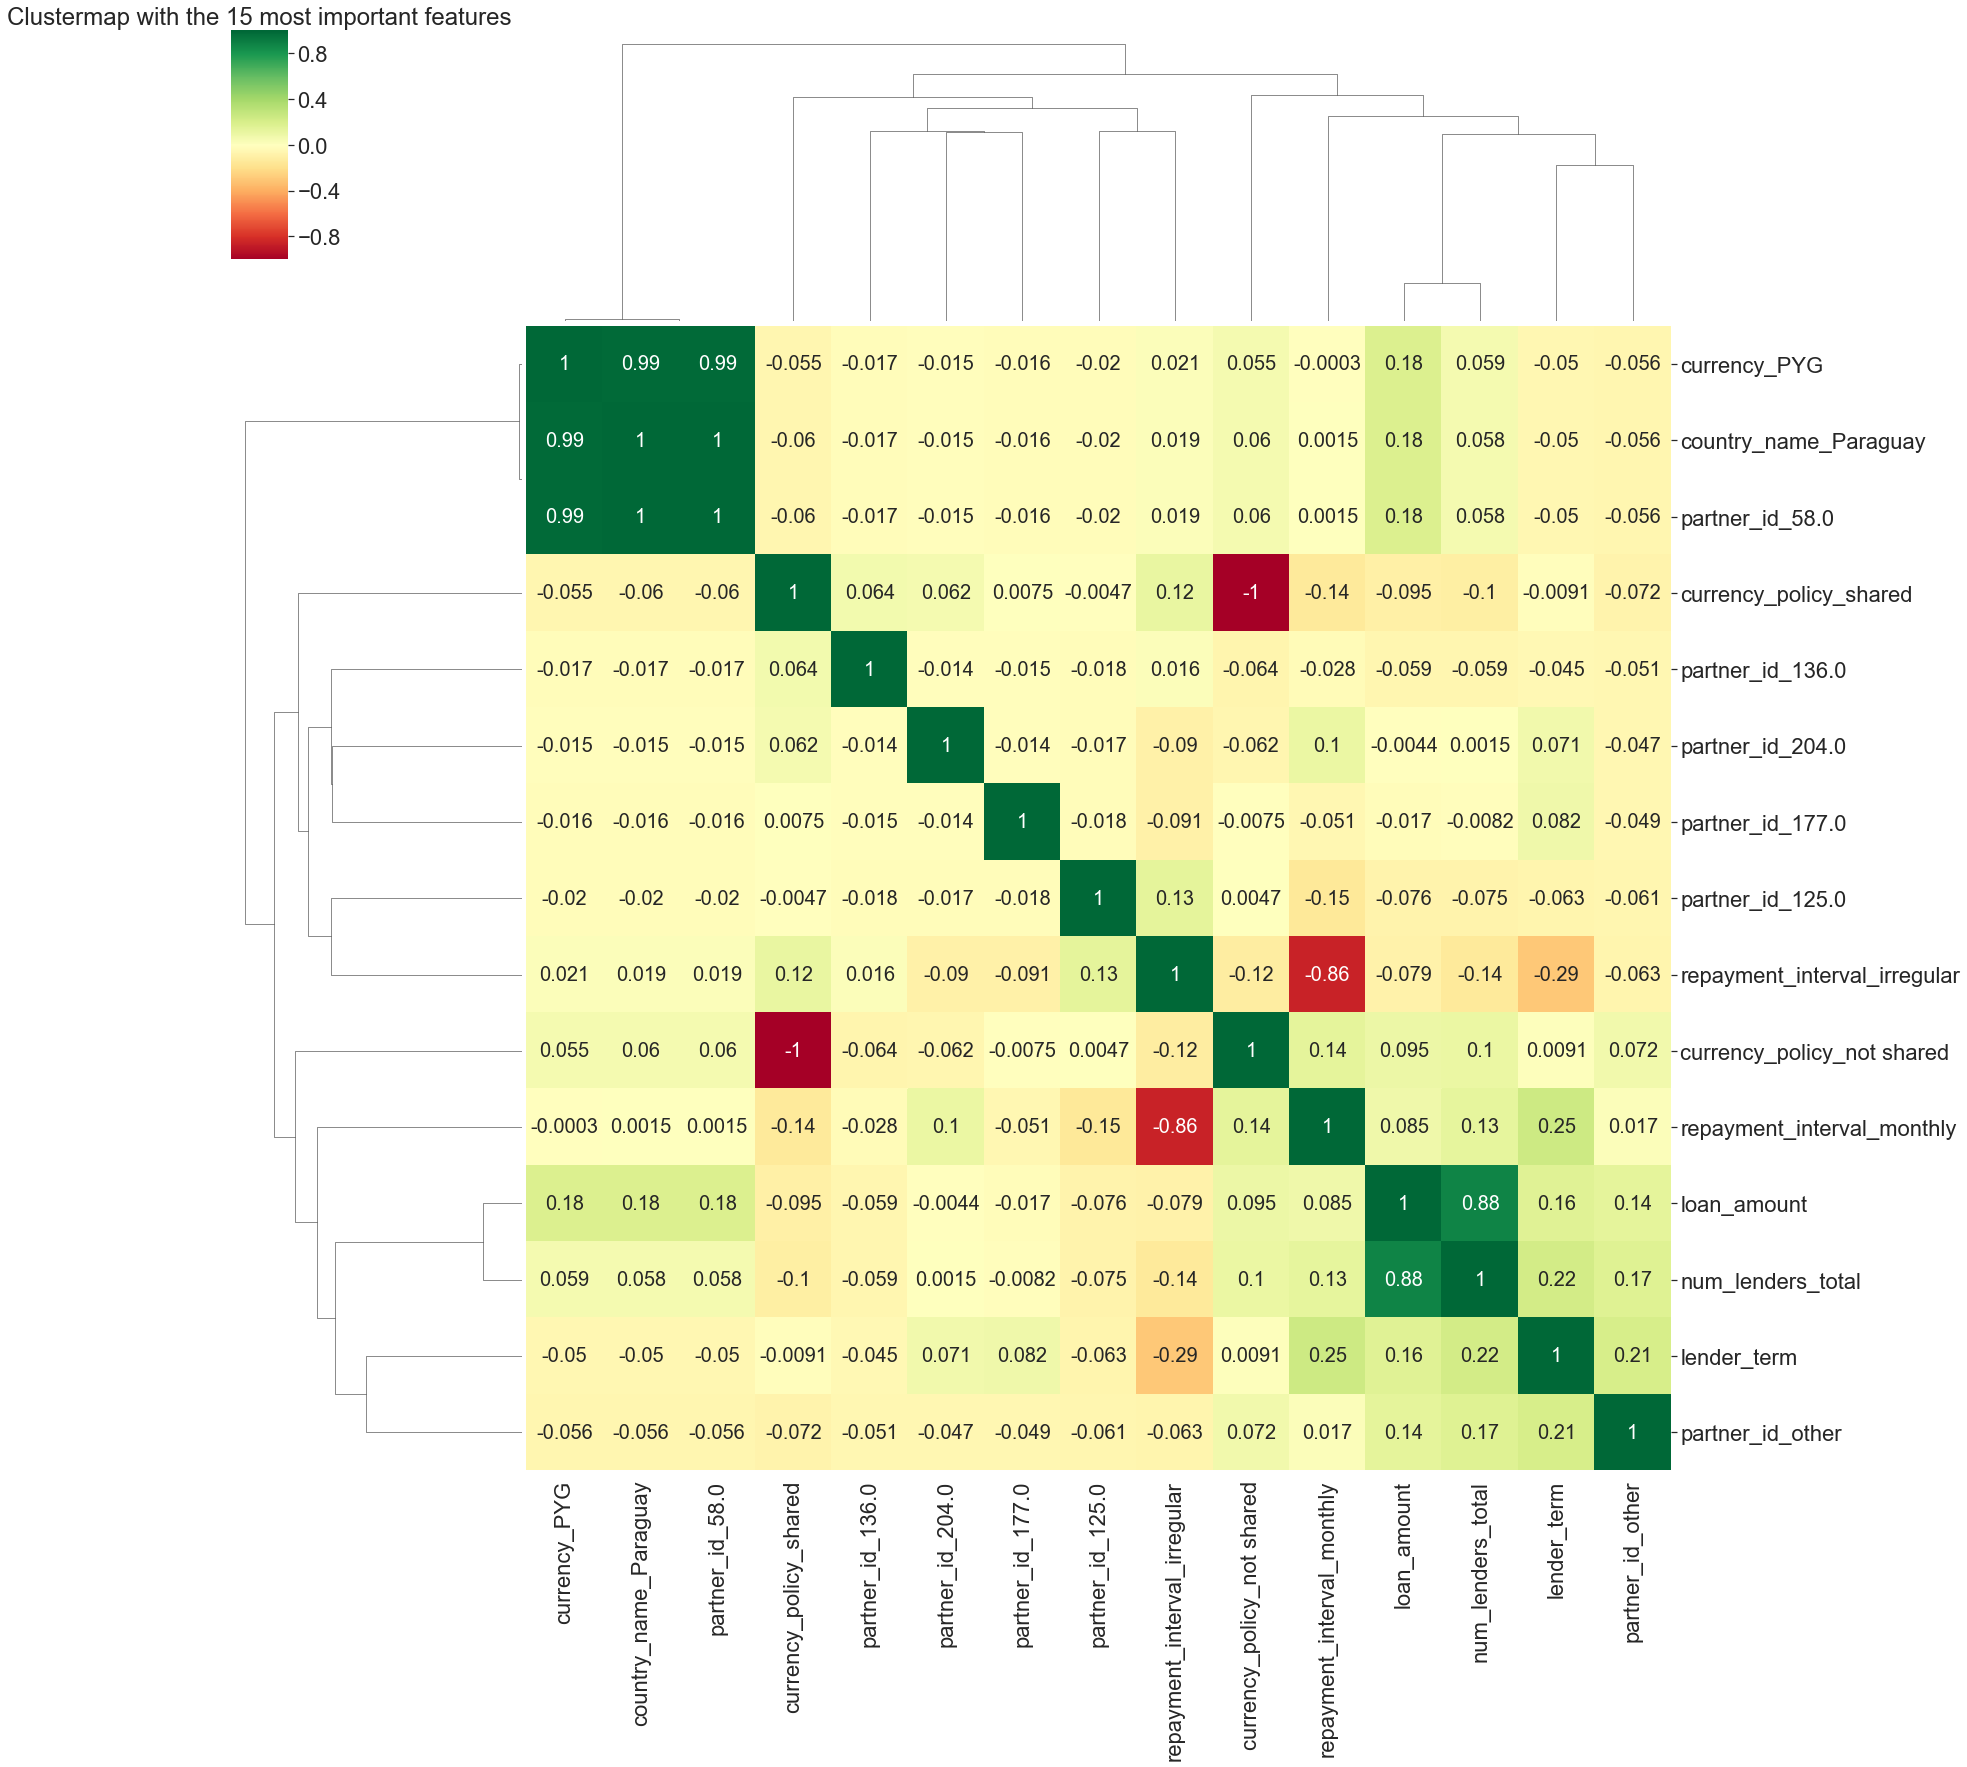

In [225]:
# clustermap with some of the variables
variables_to_clustermap = final_df[cum_imp_15.index]

# map
sns.clustermap(variables_to_clustermap.corr(method='pearson'), cmap='RdYlGn', annot=True, annot_kws={"size": 20})

plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0)
plt.title('Clustermap with the 15 most important features')
plt.show()

For example, one of the most patent relations we see is that 99% of loans to Paraguay are in Guarani, their currency. In this case, the main cause is probably the sharp devaluation of the Guarani during the period of time of the dataset. As an example, the USD/PYG exchanged at 3972.000 in 2008, and by 2018 that rate was 5697.113. We can relate this to the fact that the feature 'currency_policy_not_shared' contributed much more to delays than its counterpart, 'currency_policy_shared', which points to the fact that strong devaluations are difficult to deal with, specially after the 20% mark, as seen. 

However, all in all most of the features are uncorrelated with each other, which is better in terms of interpretability ease.